In [37]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random
import pandas as pd

import re
import string
from spellchecker import SpellChecker

from prettytable import PrettyTable

In [2]:
import urllib.request, json 
with urllib.request.urlopen("https://raw.githubusercontent.com/taivop/joke-dataset/master/wocka.json") as url:
    raw_json = json.load(url)

all_jokes = pd.json_normalize(raw_json)

In [3]:
# filter to just the 'one liners' category of jokes
one_liners = all_jokes[all_jokes.category=='One Liners']

In [4]:
raw_jokes = [j.lower() for j in one_liners.body] ##convert to lowercase

# remove some specific jokes which are gibberish, seem offensive, or just not useful
remove = [
    [j for j in raw_jokes if 'ã' in j][0],
    [j for j in raw_jokes if '~' in j][0],
    [j for j in raw_jokes if '1) a clear concience' in j][0],
    [j for j in raw_jokes if "the following were some comments made in the year 1957" in j][0],
    [j for j in raw_jokes if "mcdonalds drive thru" in j][0],
    [j for j in raw_jokes if "what's an innunedo" in j][0],
    [j for j in raw_jokes if "a total waste" in j][0],
    [j for j in raw_jokes if "a word involving four letters" in j][0],
    [j for j in raw_jokes if "jkfsh" in j][0]
    
]
for r in remove: raw_jokes.remove(r)

In [5]:
# Deal with some special cases before more general processing
# Select the string that is the long lists of jokes and remove that from the corpus of jokes
special_cases = ["42.7", "getting married is very much", "an aspirin", "a hooker", "onomatopoeia", "george bush", 
                "time to keep your mouth shut", "first instinct"]
cleaner_raw_jokes = raw_jokes
longjokes_list = []
for case in special_cases:
    longjoke = [j for j in raw_jokes if case in j][0] ##select
    longjokes_list.append(longjoke) ##save string to list
    cleaner_raw_jokes = [j for j in cleaner_raw_jokes if case not in j] ##remove from cleaner jokes corpus

# Deal with a special case within the special cases (the last case in the special cases list)
l_firstinstinct = longjokes_list[len(longjokes_list)-1].splitlines()
for i, l in enumerate(l_firstinstinct):
    if "----" in l: l_firstinstinct[i] = "<S>"

l_list = []
current_joke = ""
for line in l_firstinstinct:
    if line == "<S>":
        current_joke = re.sub(',', ', ', current_joke)
        l_list.append(current_joke)
        current_joke = ""
    else:
        current_joke += line
for j in l_list: cleaner_raw_jokes.append(j)


# Split the joke-lists strings into separate jokes and append each individual joke back to the joke corpus
for longjoke in longjokes_list[:-1]:
    for j in longjoke.splitlines(): cleaner_raw_jokes.append(j)

In [148]:
def clean_the_jokes(raw_jokes_list: list, spell_checker: SpellChecker,
                    min_joke_length: int=0, max_joke_length: int=100, 
                    leave_punctuation: str=""):
    """
    Clean and prepare each joke. Only saves the joke if it is greater than min_joke_length and less than max_joke_length.
    Removes all punctuation except for any specified in leave_punctuation. For example, leave_punctuation=".?" leaves periods and 
    question marks.
    """
    printable = set(string.printable) #set of printable chars
    punct = set([p for p in string.punctuation if p not in "<>" and p not in leave_punctuation]) #set of punctuation chars to remove

    # Iterate through each line (after splitting lines) and clean up characters
    cleaned_lines = []
    for j in raw_jokes_list:
        j = j +" <S>" ##add stop character to end of line
        lines = j.splitlines()
        for l in lines:
            l = ''.join([c for c in l if c not in string.whitespace[1:]]) ##remove any whitespeace chars
            l = ''.join([c for c in l if c in string.printable]) ##remove non-printable chars
            ##ensure proper spacing
            l = l.replace(".", " . ")
            l = l.replace(",", " , ")
            l = l.replace(";", " ; ")
            l = l.replace("?", " ? ")
            l = l.replace(" q ", " ") ##remove q from Q&A style jokes
            repls = [] ##pad numbers with spaces so they are individual 'words'
            for digit in range(10):
                repls.append((str(digit), " "+str(digit)+" "))
                l = l.replace(*repls[digit])

            l = ''.join([c for c in l if c not in punct]) ##remove punctuation except for special chars
            l = re.sub(' +', ' ', l) ##remove repeated spaces

            # filter out unwanted list elements - if it is blank, just spaces, or just <S>
            if (l=='') | (l==' ') | ("".join([c for c in l if c not in string.whitespace]) == "<S>"):
                pass
            else:
                cleaned_lines.append(" "+l)
        ## not perfect strategy since the text has inconsistent \r\n behavior - some jokes are cut into pieces

    # Now concatenate lines into jokes based on the stop character
    final_punct = set([p for p in string.punctuation if p not in leave_punctuation])

    jokes = []
    current_joke = ""
    for line in cleaned_lines:
        while True:
            current_joke = current_joke + line
            last_chr = line[-3:]
            if last_chr=='<S>':
                # if the last 3 characters in the line are <S>, this is the end of the joke and we should send the full joke to the list
                # unless it is too long
                if min_joke_length < len(current_joke.split())-1 < max_joke_length:
                    current_joke = current_joke.replace(" <S>", "") ##remove special char
                    current_joke = current_joke.replace(">", "") ##remove any missed brackets
                    current_joke = re.sub(' +', ' ', current_joke) ##remove repeated spaces
                    # SPELL CHECK
                    ## Split joke into individual words. Check if any word is not in the spell-check corpus
                    ## If not, replace the word with its most likely correction (unless spell checker returns None)
                    split_joke = current_joke.split()
                    for ix, word in enumerate(split_joke): 
                        if word not in spell_checker:
                            correction = spell_checker.correction(word)
                            if correction is not None:
                                split_joke[ix] = correction
                    ## Recombine the words into one string and append to output joke list
                    final_joke = ' '.join(split_joke)
                    jokes.append(final_joke)          
                current_joke = "" ##reset current joke to empty str
                break
            else: 
                #otherwise continue appending lines to this current joke
                break

    return jokes

In [149]:
def remove_bad_jokes(list_o_jokes : list, remove_words : list):
    """Remove some jokes that are insensitive, badly worded, etc."""
    jokes = []
    for joke in list_o_jokes:
        if any(w in joke for w in remove_words):
            pass
        else:
            jokes.append(joke)
    
    return jokes

In [165]:
# Init spellchecker
spellcheck = SpellChecker()

# Clean the raw jokes
jokes = clean_the_jokes(cleaner_raw_jokes, spellcheck, 10, 20, leave_punctuation="?")

# Remove jokes containing some insensitive words (a problem with webscraped jokes)
remover_string = [' rape', ' porn', ' bitch', ' condom', ' dick', ' cum', ' tits']
jokes = remove_bad_jokes(jokes, remover_string)


print(f"{len(jokes) = }")
print(f"{min(jokes, key=len) = }")
print(f"{max(jokes, key=len) = }")


len(jokes) = 741
min(jokes, key=len) = 'hey i lost my gun holster can i use yours ?'
max(jokes, key=len) = 'when everythings coming up roses its time to celebrate but when everythings coming up daisies its time to mourn'


## Save jokes to a text file

In [167]:
with open('jokes.txt', 'w') as f:
    for line in jokes:
        f.write(f"{line}\n")

---

In [166]:
[j for j in jokes if ' ass' in j]

['we are born naked wet and hungry and get slapped on our ass then things get worse',
 'i how do you keep a jack ass in suspense ? a ill tell you tomorrow',
 'why is it that there are so many more horses asses than there are horses ? i gordon giddy',
 'i dont know much about prison but it sounds like a pain in the ass',
 'could you drive any better if i shoved that cell phone up your ass ?',
 'hi im an fine art appraiser and your ass is priceless',
 'when you pull her pants down her ass is still in them']

In [9]:
words = set(' '.join([j for j in jokes]).split(' '))
words = [w for w in words if w != ""] ##remove empty string
len(words)

2444

In [8]:
chars = sorted(list(set(''.join(jokes)))) 
stoi = {s:i+1 for i, s in enumerate(chars)} ##create dictionary mapping from char to int
stoi['.'] = 0 ##add special start/end character
itos = {i:s for s, i in stoi.items()}

len(chars)

38

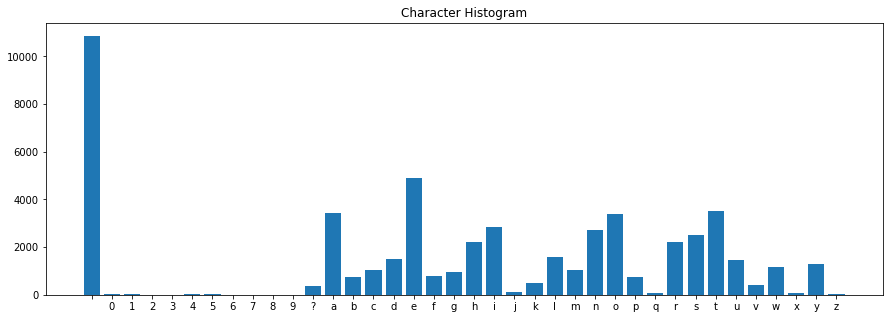

In [10]:
corpus = ''.join(jokes)
count_letters = dict()

for c in chars:
    count_letters[c] = corpus.count(c)

plt.figure(figsize=(15,5))
plt.bar(range(len(count_letters)), list(count_letters.values()), align='center')
plt.xticks(range(len(count_letters)), list(count_letters.keys()))
plt.title("Character Histogram")
plt.show()

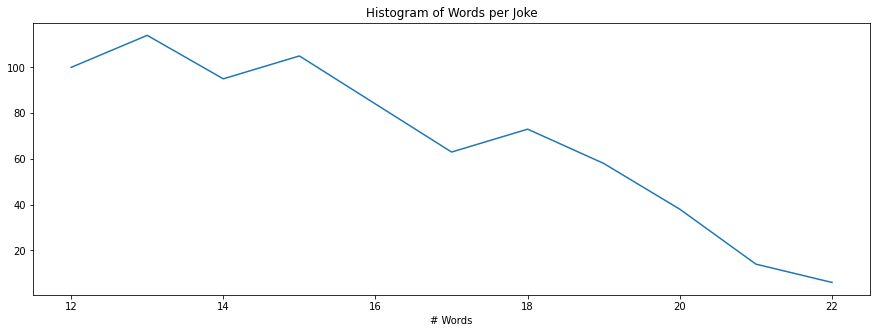

In [11]:
joke_length = {k: 0 for k in range(100)}
for j in jokes:
    length = len(j.split(" "))
    joke_length[length] += 1
joke_length = {k:v for k,v in joke_length.items() if v>0}

plt.figure(figsize=(15,5))
plt.plot(list(joke_length.keys()), list(joke_length.values()))    
plt.title("Histogram of Words per Joke")
plt.xlabel("# Words")
plt.show()